In [288]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import decimal
from scipy.stats import norm

### Fonctions générales:

$\to$ On définit la fonction $W(n,P)$ qui génère une matrice $(W_{i,k})$ générée suivant une loi donnée centrée réduite avec $W^i_0 = 0$.



$\to$ On définit la fonction $\texttt{gen_X}(n,X_0,\sigma,\lambda, \delta,P, W)$ qui étant donné à un vecteur à $n$ dimensions de départ $X_0$ simule $P$ pas des actifs $X(P\delta) = (X_1(P\delta), \cdots, X_n(P\delta))$ où l'équation d'évolution est la suivante:
$$X_i(t_{k+1}) = X_i(t_k)e^{-\lambda \delta} + \mu(1-e^{-\lambda \delta})+ \sqrt{\delta} \sigma W_{i,k}  \text{ (équation 1)}$$

$\to$ Pour le cas particulier de $W_k^i$ i.i.d et suit la loi gaussienne centrée réduite, on fait la remarque que pour $k\in [|1,n|]$ et un temps $t_P = T$, $X_k(t_P)$ est somme de gaussiennes indépendantes, on déduit que $X_k(t_P)$ est aussi une variable gaussienne. Les caractéristiques de cette gaussienne se déduisent aisément par la relation de récurrence de l'équations $(1)$, pour $N\in \textbf{N}$, en notant $\mu_{N,k}$ la moyenne de cette gaussienne et $\sigma_{P,k}$ sa variance:
$$\begin{cases}
\mu_{P,k} = e^{-\lambda \delta}\mu + \mu(1-e^{-\lambda \delta})\\
\sigma_{P,k}^2 = e^{-2\lambda\delta}\sigma_{P-1,k}^2+ \delta \sigma^2 
\end{cases}
$$

On résout aisément, on trouve:
$$\mu_{P,k}  = \mu\text{ , }\sigma_{P,k}^2 = r(1-e^{-2P\lambda \delta}) \text{ où }r  =\dfrac{\delta \sigma^2}{1-e^{-2\lambda \delta}}$$
$\to$ On définit alors la fonction $\texttt{gen_X_particulier}(X_0,P,n,\sigma,\lambda, \delta)$ qui renvoie directement le résultat au temps $T$ d'une simulation.


On définit la fonction $\texttt{insolvance_1}(v, C)$ qui étant donné un vecteur $v =X(T)$ des actifs à l'écheance, renvoie la liste des banque insolvante. On fait la remarque suivante:
$$D_{k}^T = D_{k-1}^T\cup ( D_{k}^T -  D_{k-1}^T)$$

$\to$ On définit la fonction impact $I(X_0,P\propto T, F,R)$ où $F$ est le résultat de insolvance_1.

In [109]:
X_0 + np.random.normal(size = (10,5))

array([[15.64032057, 13.1464663 , 15.71423012, 15.40088166, 15.98187493],
       [15.68732574, 14.39765668, 13.30835672, 17.25499208, 14.6244304 ],
       [15.87322895, 14.53173259, 13.79083867, 16.69019146, 14.33726567],
       [14.38215057, 14.18233477, 14.65142765, 14.96535674, 16.56187331],
       [16.37843652, 15.23101777, 14.89914509, 15.16603758, 13.5321459 ],
       [15.34676618, 15.7072201 , 15.01605631, 13.89584658, 15.62972344],
       [14.76130266, 13.81407188, 15.83599734, 14.78940532, 13.31512597],
       [16.43306681, 15.3252251 , 15.39786417, 14.56585486, 15.56684501],
       [15.06638409, 15.23960247, 14.18125179, 12.88774891, 13.5533539 ],
       [16.14635001, 15.48553244, 15.97744973, 14.02652782, 13.70444801]])

In [290]:
#####Fonctions générales
def W_1(n,P = 365):
    W_1 = np.random.randn(n,P)
    W_1[:, 0]= 0
    return W_1

def gen_X(X_0, W,P = 365, n =5, sigma = 8, lbda = 20, delta =1/365):
    A = np.full((n,P),0.0)
    A[:,0] = X_0
    for p in range(1,P):
        A[:,p] =A[:,p-1]*np.exp(-lbda*delta) + X_0*(1- np.exp(-lbda*delta))+np.sqrt(delta)*sigma *W[:,p]
    return A

def gen_X_particulier(X_0,N=1, sigma_2 = 1.689):
    return X_0+np.sqrt(sigma_2)*np.random.normal(size = (N,n))

def insolvance_1(E,v, C, R = 0.05):
    assert len(v) == len(C)
    assert E.shape[0] == len(v) and E.shape[1] == len(v)
    used_up = np.full(len(v),False)
    l=-1
    while True:
        used_up+= v<C
        v = (v - (1-R)*np.sum(E*(used_up), axis = 1))*(v>=C)
        if (l == np.sum(used_up)):
            break
        l = np.sum(used_up)
    return used_up

def I(X,F,R = 0.05, P = 365):
    return np.sum((X + (1-R)*np.sum(E[~F], axis = 0))*(F))

vectorized_impact = np.vectorize(I, signature='(n),(n)->()')

def calculate_var_cvar(impacts, alpha):
    sorted_impacts=np.sort(impacts)
    #calculons value-at_risk
    var_index=int((1 - alpha) * len(sorted_impacts))
    var=sorted_impacts[var_index]
    #Conditional VAR
    cvar = np.mean(sorted_impacts[var_index:])
    return var, cvar

def adapted_impact(x, F):
    return I(x,F)  +np.sum(mu-x[~F]) 

vectorized_adapted_impact = np.vectorize(adapted_impact, signature='(n),(n)->()')


def transformation_sur_quantile(x,quantile,rho,M):
    rho_bar=np.sqrt(1-rho**2)
    y=np.random.randn(M,len(x))
    for i in range(M):
        xtilde = rho*x+sigma*rho_bar*y[i]+mu*(1-rho)
        F=insolvance_1(E,xtilde,C,R)
        si=adapted_impact(xtilde, F)>quantile
        x = xtilde*(si) + x*(not si)
    return x
def NiveauxSplitting(a, seuil ,M, C , E, rho = 0.6, N = 10000, R = 0.05):
    X = gen_X_particulier(X_0,N)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=X)
    impacts = vectorized_adapted_impact(X, insolvances)
    #I_brut=impacts.copy() #On conserve la liste I non-triée
    #impacts.sort()
    sorts = np.argsort(impacts)
    quantiles = []
    indice = int(np.ceil((1-seuil)*N))-1
    quantiles.append(impacts[sorts[indice]])
    quantile=quantiles[-1]
    while quantiles[-1] < a:
        initial=len(X)
        indices = impacts>quantiles[-1] 
        X = X[indices]
        try:
            choix = np.random.randint(0,len(X),size = initial-len(X))
        except:
            break
        sous_X = X[choix]
        Z = np.apply_along_axis(lambda v: transformation_sur_quantile(v, quantiles[-1], rho, M), axis=1, arr=sous_X)
        #Z= [transformation_sur_quantile(x, quantiles[-1], rho, M) for x in sous_X]
        X = np.concatenate((X, Z), axis=0)  
        insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=X)
        cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
        impacts = vectorized_adapted_impact(X, insolvances)
        indice=int(np.ceil((1-seuil)*N))-1
        sorts = np.argsort(impacts)
        quantiles = np.append(quantiles, impacts[sorts[indice]])
    ## On rajoute a
    niveaux = np.append(quantiles, a)
    ## Dernière probabilité :
    plast = np.mean(impacts>a)
    return niveaux, plast



## Premier modèle: Capitaux indépendants

On s'interesse au calcul de différents quantités probabilisites relatifs aux $X_i$. On utilise les différents méthodes de simulations exposés lors des cours magistraux:

$\to$ Méthode de Monte-Carlo Naif.

$\to$ Méthode d'échantillonage d'importance.

$\to$ Méthode MCMC.

On estime les quantités suivantes:

$\to \textbf{P}(|D_n^T| = k)$ avec $k\in[|0,n|]$, la probabilité qu'on a insolvance d'exactement $k$ banques.

$\to$ Estimation de la Value-at-Risk et de la Conditional Value-at-Risk de la distribution $I(T)$ pour différents seuils $\alpha$ proches de $1$, ainsi que des intervalles de confiance associés aux estimateurs.

$\to$ Distribution de l’impact de défaut conditionnellement à l'effondrement du réseaux tout entier.

Pour ce cas particulier, $\textbf{ on utilise que les valeurs finaux de $X$}$, on se sert alors de la fonction $\texttt{gen_X_particulier}$.

#### Paramètres du modèle

On prend $n=5$. On se sert de la fonction $\texttt{gen_X_particulier}$. Plus tard on prend des valeurs assez grande de $n$.

In [291]:
####Constantes
N = 100000 #nombres de simulations
sigma = 8
lbda = 20
delta =1/(365)

In [292]:
## Hypothèse du premier modèle:
n = 5 
P = 365
sigma_2 = delta*sigma**2 *(1-np.exp(-2*P*lbda*delta)) /(1-np.exp(-2*lbda*delta) )
R = 0.05
E = np.array([[0,3,0,0,6],
              [3,0,0,0,0],
              [3,3,0,0,0],
              [2,2,2,0,2],
              [0,2,3,3,0]])

mu = 15. ## commune
c = 10 ## commune
X_0 = np.full(n,mu)
C = np.full(n,c)

In [264]:
#Génération de de trajectoire de $n = 5$ banques entre $t=0$ et $t=T$
W = W_1(n)
X = gen_X(X_0,W)

KeyboardInterrupt: 

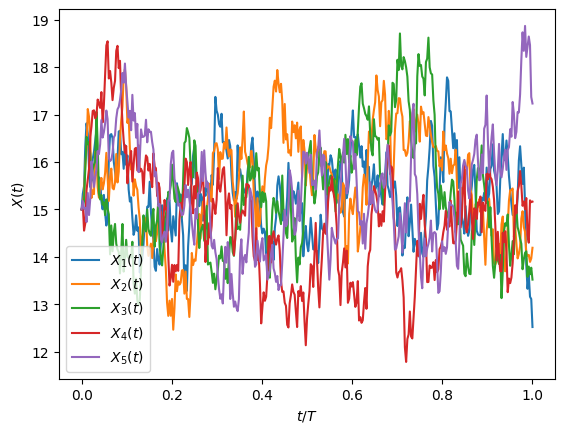

In [293]:
#Visualisation
base = np.linspace(0,1, num =X.shape[1])
for j in range(X.shape[0]):
    plt.plot(base,X[j,:], label = '$X_'+str(j+1)+'(t)$')
plt.xlabel("$t/T$")
plt.ylabel('$X(t)$')
leg = plt.legend(loc=0)
plt.show()

## $\blacktriangleright$ Monte-Carlo Naif

In [115]:
## Génération de $N$ trajectoires de $X$.
echantillons = gen_X_particulier(X_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
impacts = vectorized_impact(echantillons, insolvances)

### $\to \textbf{P}(|D_n^T| = k)$ avec $k\in[|0,n|]$.

On a $|D_n^T|= |D_n^T|(X)$ et donc pour des $(X_i)$ i.i.d, on a à $k$ fixé par TCL+Slutsky et LFN:
$$\overline{c}_k^N = \dfrac{1}{N}\sum_{k=1}^N \overbrace{\textbf{1}_{|D_n^T|(X_i)= k}}^{\text{i.i.d dans }\{0,1\}\text{, admet donc tous moment}}\xrightarrow[N\to +\infty]{}\textbf{P}(|D_n^T|(X)= k) =p_k$$
$$\dfrac{\sqrt{N}}{\sqrt{\overline{c}_k^N (1-\overline{c}_k^N)}}(\overline{c}_k^N - p_k)\xrightarrow[N\to +\infty]{\mathcal{L}}\mathcal{N}(0,1)$$
On obtient un intervalle de confiance, en notant $q$ la quantile d'ordre $0.95$ de la loi normale:
$$p_k \in[\overline{c}_k^N - \rho^N_k ,\overline{c}_k^N + \rho^N_k] \text{ où }\rho^N_k = q \dfrac{\sqrt{\overline{c}_k^N (1-\overline{c}_k^N)}}{\sqrt{N}}$$

Probabilités {0: 0.99967, 1: 0.00021, 2: 3e-05, 3: 2e-05, 4: 1e-05, 5: 6e-05}
Longueur des intervalles de confiance {0: 9.447405496587288e-05, 1: 7.536874756115502e-05, 2: 2.8489273180225865e-05, 3: 2.326151045493964e-05, 4: 1.6448454026627766e-05, 5: 4.028931214221583e-05}


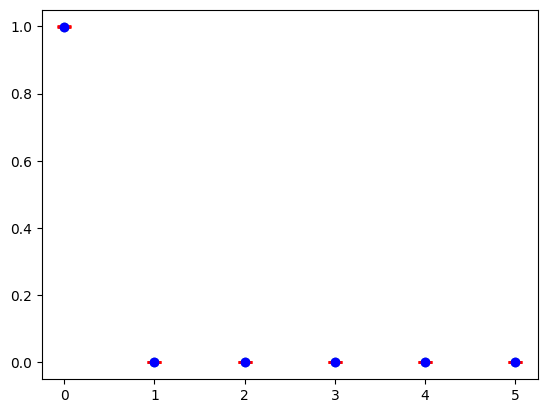

In [116]:
## Génération de $N$ valeurs finaux de $X$ pour chaque k
probas = np.bincount(cardinaux, minlength = n+1)/N
q = stats.norm.ppf(0.95)
var = q *np.sqrt(probas*(1-probas))/np.sqrt(N)
plt.scatter(np.arange(n+1), probas)
plt.errorbar(np.arange(n+1),probas, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.plot()
print('Probabilités', dict(zip(np.arange(n+1), probas)))
print('Longueur des intervalles de confiance', dict(zip(np.arange(n+1), var)))

### $\to$ Estimation de la Value-at-Risk et de la Conditional Value-at-Risk de la distribution $I(T)$ pour différents seuils $\alpha$ proches de $1$, ainsi que des intervalles de confiance associés aux estimateurs.

In [117]:
##Simulation de nbr*N_reduit simulations
alphas = np.linspace(0.99, 1, num = 10)
nbr = 10
varL = np.full((nbr, alphas.shape[0]),0)
cvarL = np.full((nbr, alphas.shape[0]),0)
for nb in range(nbr):
    echantillons = gen_X_particulier(X_0,N)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    impacts = vectorized_impact(echantillons, insolvances)
    for i in range(len(alphas)):
        alpha = alphas[i]
        var, cvar = calculate_var_cvar(impacts, alpha)
        varL[nb,i] = var
        cvarL[nb,i] = cvar

[]

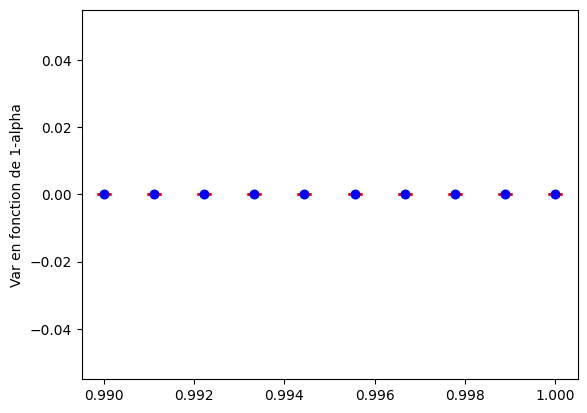

In [118]:
varA = np.mean(varL,axis = 0)
varvar = np.var(varL, axis =0)
plt.scatter(alphas, varA)
plt.errorbar(alphas,varvar, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.ylabel('Var en fonction de 1-alpha')
plt.plot()

[]

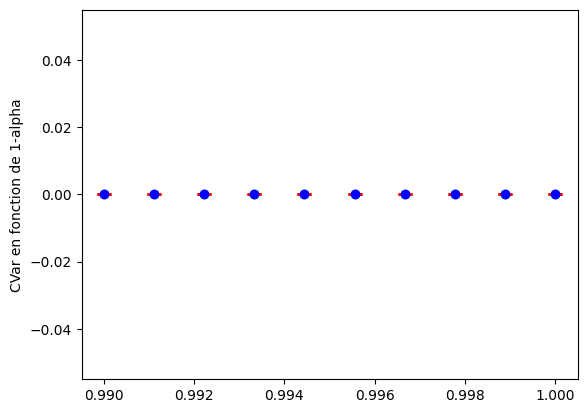

In [294]:
cvarLA =np.mean(cvarL,axis = 0)
varvarLA = np.var(cvarL, axis =0)
plt.scatter(alphas, cvarLA)
plt.errorbar(alphas,varvarLA, yerr=var, fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.ylabel('CVar en fonction de 1-alpha')
plt.plot()


In [120]:
## Distribution de I(T) condtionnelle
echantillons = gen_X_particulier(X_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
impacts = vectorized_impact(echantillons, insolvances)
dist = impacts[cardinaux == n]

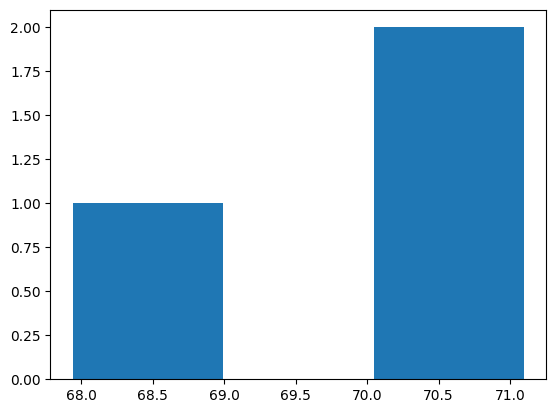

In [121]:
plt.hist(dist, bins='auto')
plt.show()

En ce basant sur ces résultats, la méthode de Monte Carlo $\textbf{n'est pas suffisante}$. Nous optons pour d'autre méthodes dite de réduction de variance, comme suit:

## $\blacktriangleright$ Échantillonage d'importance (Importance sampling)

L'idée est utiliser l'échantillonage par importance avec une distribution de telle manière à augmenter la probabilité que $|D_n^T|$ prennent des valeurs elevées, on propose de réduire $\mu$ en $\mu'$ de telle manière qu'il y'a plusieurs fois la réalisation de $X_i\leq c_i$. On pose alors:
$$X' \hookrightarrow \mathcal{N}\bigg(\mu' I_n, \dfrac{\delta \sigma^2}{1- e^{-2\lambda \delta}} (1- e^{-\lambda T}) I_n\bigg) $$

### $\to \textbf{P}(|D_n^T| = k)$ avec $k\in[|0,n|]$.

On note $f^n_{\mu, \sigma}$ la densité de la loi $\mathcal{N}(\mu I_n, \sigma^2 I_n)$. On a alors:
$$\textbf{P}(|D_n^T| = k) = \textbf{E}_X\bigg[\textbf{1}_{|D_n^T|(X) = k}\bigg] =  \textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \dfrac{f^n_{\mu, \sigma_N}(X)}{f^n_{\mu', \sigma_N}(X')}\bigg]=\textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \cdot \text{exp}\bigg(\dfrac{\sum_{i=1}^n (X'_i-\mu')^2 -(X'_i-\mu)^2  )}{2\sigma_N^2}\bigg)\bigg]$$

In [122]:
### Recherche empirique d'un mu prime optimal
mu_primes = np.linspace(min(C)-1,mu+1,num = 500 )
d_mu_p = np.full_like(mu_primes,0) 
cards = np.full_like(mu_primes,0) 
for i in range(len(mu_primes)):
    mu_prime = mu_primes[i]
    Xp_0 =np.full(n,mu_prime)
    echantillons = gen_X_particulier(Xp_0,10000)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
    d_mu_p[i] = np.mean(cardinaux)
    cards[i] = len(np.unique(cardinaux))/(n+1)
plt.plot(mu_primes, d_mu_p)
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.scatter(mu_primes, cards)
plt.show()

On prend $\mu' = 11$. On envisage le problème calculatoire suivant:

In [ ]:
mu_p=11
Xp_0 =np.full(n,mu_p)
echantillons = gen_X_particulier(Xp_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
cardinaux  = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
classes = np.full(n+1,0.0)
for i in range(echantillons.shape[0]):
    try:
        #print(np.exp(np.sum((echantillons[i] - mu_p)**2 -(echantillons[i] - mu)**2 )))
        classes[cardinaux[i]]+= np.exp(np.sum((echantillons[i] - mu_p)**2 -(echantillons[i] - mu)**2 ))
        print(classes[cardinaux[i]])
    except OverflowError:
        print("Problème de débordement de mémoire")
        break
print(classes/N)

0.04007048685758797
0.04007048685758797
4.564774281886856e-77
0.04007048685758797
0.04007048685758797
0.04007048685758797
0.04007048685758797
0.04007048685758797
0.04007048685758797
77352331979089.78
77352331979089.78
77352331979089.78
3.4890741830253497e-56
77352331979089.78
3.514275988579505e-56
77352331979106.4
3.5142759885807e-56
77352331979106.4
84037802227038.64
84037802227038.64
3.5142759885807e-56
4.837611413427836e-55
84037802227038.64
84037802227038.64
84037802227038.64
84037802227038.64
9.566696055994976e-55
9.571185723804696e-55
84037802227038.64
84037802227038.64
9.571186076452723e-55
84037802227038.64
84037802227038.64
84037802227038.64
9.625121577715684e-55
3.73662419252467e+16
3.73662419252467e+16
9.625121577716324e-55
3.73662419252467e+16
9.625121577716326e-55
9.625136499590644e-55
3.73662419252467e+16
3.73662419252467e+16
3.73662419252467e+16
3.73662419252467e+16
3.73662419252467e+16
3.73662419252467e+16
3.736628905980711e+16
9.625136581990487e-55
3.736628905980711e+1

6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
1.7079033743965657e-50
6.968597558740493e+54
1.7082187772658474e-50
6.968597558740493e+54
1.7082188234127045e-50
1.7103169350179574e-50
6.968597558740493e+54
6.968597558740493e+54
1.7103169350179574e-50
1.7103169350900796e-50
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
1.710321953781529e-50
1.710346515504696e-50
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
1.7141572386137902e-50
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
6.968597558740493e+54
1.7141572386137902e-50
6.968597558740493e+54
6.968597558740493e+54
6.

3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.222638707853111e-50
3.1777435026077303e+55
3.2226447919047774e-50
3.1777435026077303e+55
3.2226447919047774e-50
3.1777435026077303e+55
3.1777435026077303e+55
3.2226447919047774e-50
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.2226449801795257e-50
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.222647788259748e-50
3.1777435026077303e+55
3.222647788259748e-50
3.1777435026077303e+55
3.222647788259748e-50
3.222647788259748e-50
3.1777435026077303e+55
3.222647788259748e-50
3.222647788274204e-50
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303e+55
3.1777435026077303

On a ainsi des $\textbf{problèmes calculatoires et de débordement de mémoire}$ pour un importance sampling basé sur un changement de moyenne.

Du aux erreurs d'arrondis, nous avons décidé d'appliquer l'échantillonage d'importance à la variance au lieu de la moyenne 

On pose alors:
$$X' \hookrightarrow \mathcal{N}\bigg(\mu I_n, (\sigma_N')^2\bigg) \text{ avec }\sigma_N'^2 = \sigma_N^2 + \Delta \sigma^2 $$ 
On note $f^n_{\mu, \sigma}$ la densité de la loi $\mathcal{N}(\mu I_n, \sigma^2 I_n)$. On a alors:
$$\textbf{P}(|D_n^T| = k) = \textbf{E}_X\bigg[\textbf{1}_{|D_n^T|(X) = k}\bigg] =  \textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \dfrac{f^n_{\mu, \sigma_N}(X)}{f^n_{\mu, \sigma_N'}(X')}\bigg]=\sqrt{\dfrac{(\sigma_N')^2}{\sigma_N^2}}^5\textbf{E}_{X'}\bigg[\textbf{1}_{|D_n^T|(X') = k} \cdot \text{exp}\bigg(-\sum_{i=1}^n (X'_i-\mu)^2  \bigg(\dfrac{1}{2\sigma_N^2} - \dfrac{1}{2\sigma_N'^2}\bigg)\bigg]$$

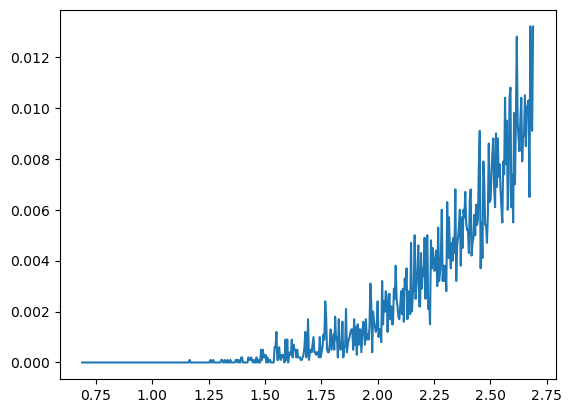

In [ ]:
### Recherche empirique d'un sigma_2_p optimal
sigma_primes_2 = np.linspace(sigma_2-1,sigma_2+1,num = 500 )
d_sigma_primes_2 = np.full_like(sigma_primes_2,0) 
cards = np.full_like(sigma_primes_2,0) 
for i in range(len(sigma_primes_2)):
    sigma_prime  = sigma_primes_2[i]
    echantillons = gen_X_particulier(X_0,10000, sigma_2 = sigma_prime)
    insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=echantillons)
    cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis = 1, arr = insolvances)
    d_sigma_primes_2[i] = np.mean(cardinaux)
    cards[i] = len(np.unique(cardinaux))/(n+1)
plt.plot(sigma_primes_2, d_sigma_primes_2)
plt.show()

On prend $\Delta \sigma^2 = 2 $.

Probabilités {0: 0.9960234155447706, 1: 0.00024122760734418026, 2: 1.3593415139614857e-05, 3: 4.432055756379051e-06, 4: 2.6441658541480347e-06, 5: 4.393529746540178e-05}
Longueur des intervalles de confiance {0: 0.0003273536112220655, 1: 8.07771215364397e-05, 2: 1.9177350029901652e-05, 3: 1.095037273089245e-05, 4: 8.458065205541903e-06, 5: 3.447660568018328e-05}


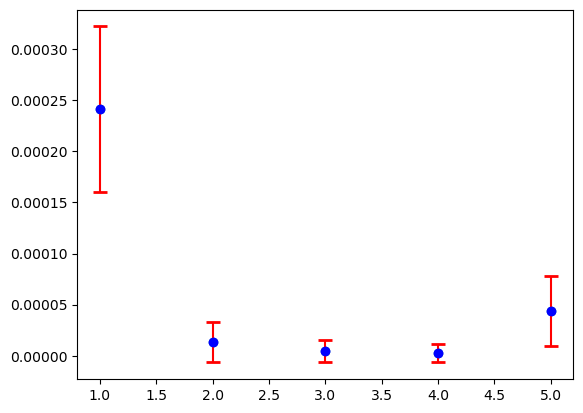

In [ ]:
sigma_p = sigma_2 + 2
facteur = 1 / sigma_p - 1 / sigma_2
probas = np.zeros(n + 1)
X= gen_X_particulier(X_0,N,sigma_2 = sigma_p)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E, v, C, R), axis=1, arr=X)
cardinaux = np.apply_along_axis(lambda v: np.sum(v), axis=1, arr=insolvances)
for k in range(X.shape[0]):
    r = cardinaux[k]
    probas[r] += np.exp(0.5 * facteur * np.sum((X[k] - mu)**2))
adjustment_factor = (sigma_p / sigma_2)**(5 / 2)
probas = adjustment_factor * probas / X.shape[0]
q = stats.norm.ppf(0.95)
var = q *np.sqrt(np.abs(probas*(1-probas)))/np.sqrt(N)
plt.scatter(np.arange(1,n+1), probas[1:])
plt.errorbar(np.arange(1,n+1),probas[1:], yerr=var[1:], fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.plot()
print('Probabilités', dict(zip(np.arange(n+1), probas)))
print('Longueur des intervalles de confiance', dict(zip(np.arange(n+1), var)))

[]

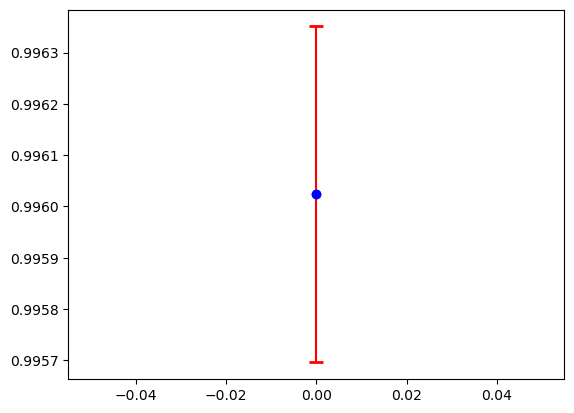

In [ ]:
plt.scatter(0, probas[0])
plt.errorbar(0,probas[0], yerr=var[0], fmt='o', color='b', ecolor='r', capsize=5, capthick=2)
plt.plot()


## $\blacktriangleright$ Méthode de splitting

On se sert de la méthode de splitting qui est une sorte de 'diviser pour regner'. On utilise la formule de Bayes comme suit:
$$\textbf{P}(I(T)> q = q_r) = \prod_{i=0}^{r-1}\textbf{P}(I(T)>q_{i+1}|I(T)>q_i) \text{ avec }q_0 = -\infty$$
L'avantage de cette méthode est que l'on peut controller que:
$$\textbf{P}(I(T)>q_{i+1}|I(T)>q_i)\simeq \varepsilon \text{ un seuil fixé  tel que }\textbf{P}(I(T)> q = q_r)  \simeq \varepsilon^r \text{ où }r \text{ le nombre de splits} $$

On compare l'efficacité de cette méthode face au MC naif:

In [ ]:
#Paramètre de splitting
a=10
rho=0.5
rho_bar=np.sqrt(1-rho**2)
M=20
m=15
sigma=np.sqrt(sigma_2)
seuil=0.1
niveaux,plast = NiveauxSplitting(a, seuil ,20, C , E, rho, N, R)
print("Nombre de niveaux = {}:".format(len(niveaux)-1)) 
Proba_emp_split=plast*seuil**(len(niveaux)-1)
# estimation par Monte-Carlo naif

X = gen_X_particulier(X_0,N)
insolvances = np.apply_along_axis(lambda v: insolvance_1(E,v,C,R), axis=1, arr=X)
impacts = vectorized_adapted_impact(X, insolvances)
Proba_emp_MonteCarlo=np.mean(impacts>a)
print("Splitting fournit la probabilité = {:1.3e}".format(Proba_emp_split))
print("Monte-Carlo naif fournit = {:1.3e}".format(Proba_emp_MonteCarlo))

Valeurs successives des niveaux
[ 3.92971476  7.01273592  9.3860392  21.45796662]
Nombre de niveaux = 4:
Splitting fournit la probabilité = 5.650e-05
Monte-Carlo naif fournit = 1.000e-03


On obtient une fonction de répartition empirique:

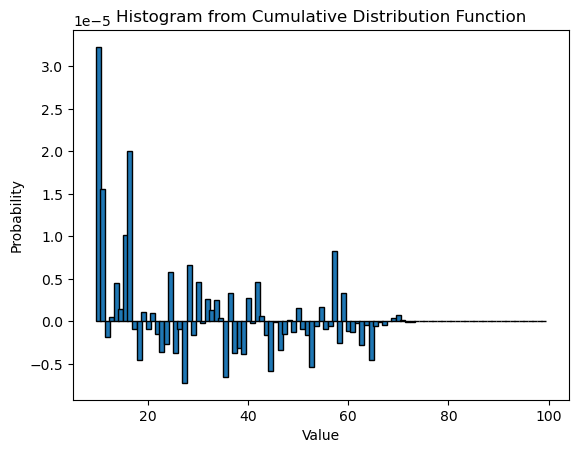

In [ ]:
def CumEmpirique(x):
    niveaux,plast = NiveauxSplitting(x, seuil ,20, C , E, rho, N, R)
    return 1 - plast*seuil**(len(niveaux)-1)
bin_edges = np.linspace(min(C), 100,num = 100) 

# Calculate bin heights
bin_heights = [CumEmpirique(bin_edges[i])  for i in range(len(bin_edges))]

# Plot the histogram
plt.bar(bin_edges[:-1], bin_heights, width=1, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Histogram from Cumulative Distribution Function')
plt.show()

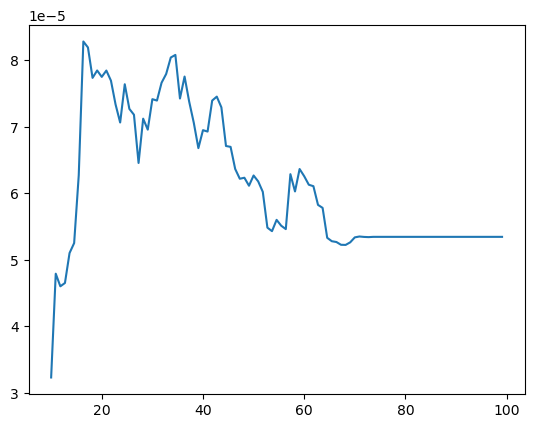

In [ ]:
cum_sim = np.cumsum(bin_heights)
plt.plot(bin_edges[:-1],cum_sim)

## $\blacktriangleright$ Usage de graphes

In [ ]:
###Fonctions utiles
def check_matrix(M,E):
    for i in range(M.shape[0]):
        arg = np.argwhere(M[i]>0)
        if len(arg)==0:
            continue
        else:
            if E[arg[0][0]][i]>0:
                
                continue
            else: 
                return False
    return True
def matrix_to_I(M, E, C, R=0.05, n=5):
    if not check_matrix(M, E):
        raise Exception("Matrices non compatibles")
    
    I = np.zeros(n)
    L = [[] for _ in range(n)]
    count = 0
    
    while count < n:
        for k in np.argwhere(I == 0):
            i = k[0]
            if len(np.argwhere(M[i] > 0)) == 0:
                L[i].append(i)
                I[i] = C[i]
                count += 1
            else:
                arg = np.argwhere(M[i] > 0)[0]
                if I[arg] == 0:
                    continue
                else:
                    L[i] = L[arg[0]].copy()
                    L[i].append(i)
                    r = C[i] + (1 - R) * np.sum([E[i][k] for k in L[i]])
                    I[i] = r
                    count += 1
    
    return I

On remarque qu'une risque systémique souvent se passe par une sucession d'insolvances qu'on peut modéliser par des graphes. Par exemple, un tel scénario étant donné notre matrice est le suivant:
$$1 \to 5 \to\begin{cases}
3\\
2\\
4\\
\end{cases} \text{ ou bien }\begin{cases}
1\to 2\\
4\to \begin{cases}
5\\
3
\end{cases}
\end{cases}$$
Les différents cas possibles sont prédeterminé grace à la structure de la matrice $E$. Par exemple pour la matrice suivante:

$$
E = \begin{pmatrix}
0 & 3 & 0 & 0 & 0\\
4 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 5\\
0 & 0 & 0 & 2 & 0\\
\end{pmatrix}
$$
On a, avec défaillance de la banque 3, les seuls cas de figure suivants:
$$\mathcal{C}_1:\begin{cases}
1\to 2\\
4\to 5
\end{cases} \text{ ou }
\mathcal{C}_2:
\begin{cases}
1\to 2\\
5\to 4
\end{cases}
\text{ ou }
\mathcal{C}_3:
\begin{cases}
2\to 1\\
4\to 5
\end{cases}
\text{ ou }
\mathcal{C}_4:
\begin{cases}
2\to 1\\
5\to 4
\end{cases}$$
Les cas où on a des défaillances simultanés (par exemple $1 \text{ et } 2$) sont inclus dans le cas de défaillances successives ($X_i<C_i\implies X_i<C_i +(1-R)E_{i,j}$).


L'idée cruciale sur laquelle se base l'étude suivante est qu'on a équivalence d'un cas $\mathcal{C}_i$ et le fait que $(X_1(T),\cdots,X_n(T))\in \mathcal{I}_{\mathcal{C}_i}$ où l'on construit $\mathcal{I}_{\mathcal{C}_i}$ de près en près (voir fonction matrix_to_I). On commence par déterminer les parents $p$ de chaques composante connexe de graphe, on pose $I^p = c_p$ (la borne sur la variable $X_p$), puis on parcours les graphes, on pose $I^p = c_p + (1-R)\sum_{j\in \text{Chemin menant à i}}e_{p,j}$. On obtient, un intervalle:


$$I_{\mathcal{C}_i} = [0,I^1]\times \cdots \times [0,I^n]$$

On code tous les chemins de défaillance possibles par des matrices $G$ à valeurs dans $\mathcal{M}_n(\{0,1\})$ où pour la $i-$ème ligne, on a un unique $j\neq i$ tel que $G_{i,j} =1$ si la valeur $i$ admet un parent dans le graphe, sinon que des zéros.

Par exemple:
$$\mathcal{C}_4:
\begin{cases}
2\to 1\\
5\to 4
\end{cases} \equiv G(\mathcal{C}_4) = \begin{pmatrix}
0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & 0\\
\end{pmatrix}$$
Dans ce cas, le calcul ci-dessous fournit:


$$I_{\mathcal{C}_4}  = [0,12.85]\times[0,10]\times [0,10]\times [0,15.7]\times [0,11.9]$$


Avec un seuil fixe de $10$ et taux d'amortissement $R= 0.05$

In [ ]:



A =np.array([[0,3,0,0,0],
           [4,0,0,0,0],
           [0,0,0,0,0],
           [0,0,0,0,5],
           [0,0,0,2,0]])

example= np.array([[0,1,0,0,0],
                  [0,0,0,0,0],
                  [0,0,0,0,0],
                  [0,0,0,0,1],
                  [1,0,0,0,0]])
matrix_to_I(example,E,C,R,n)

NameError: name 'np' is not defined

Le calcul de la probabilité de cet intervalle est aisé vu le fait qu'on sait calculer $\textbf{P}(\mathcal{N}(\mu,\sigma^2)\in [0,I^p]) = F(I^p;\mu,\sigma^2) -F(0;\mu,\sigma^2)$. On obtient alors la valeur exacte(les variables supposés independants):
$$\textbf{P}(I_{\mathcal{C}_i}) = 1.055 \cdot 10^{-12}$$
Avec une simulation Monte-Carlo, on aurait besoin d'environ $10^{13}$ simulations. En supposant qu'on code une simulation en $\texttt{float64}$, une simulation prend environ $0.0078125kB$, soit pour $10^{13}$ simulation, environ $74Gb$ de mémoire simultanée.

initial_matrix = np.array([
    [0, 7, 0],
    [4, 0, 6],
    [7, 1, 0]
])
print(np.argwhere(initial_matrix[i]==1))initial_matrix = np.array([
    [0, 7, 0],
    [4, 0, 6],
    [7, 1, 0]
])
print(np.argwhere(initial_matrix[i]==1))

In [ ]:
initial_matrix = np.array([
    [0, 7, 0],
    [4, 0, 6],
    [7, 1, 0]
])
print(np.argwhere(initial_matrix[0]==0))

[[0]
 [2]]


In [ ]:
sigma = np.sqrt(sigma_2)
prob_1 = norm.cdf(12.85, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
prob_2 = norm.cdf(10, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
prob_3 = norm.cdf(10, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
prob_4 = norm.cdf(15.7, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
prob_5 = norm.cdf(11.9, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
prob = prob_1 * prob_2 * prob_3 * prob_4 * prob_5
print(prob)

1.0550305782723682e-12


In [ ]:

from itertools import product

def generate_matrices(E):
    W=E>0
    n = W.shape[0]
    indices = [np.append(np.where(W[i] == 1)[0], -1) for i in range(n)]
    
    
    all_combinations = product(*indices)
    
    matrices = []
    for combination in all_combinations:
        matrix = np.zeros_like(W)
        for i, j in enumerate(combination):
            if j != -1:  # -1 signifie que cette ligne ne prendra que des 0 
                matrix[i, j] = 1
        matrices.append(matrix)
    
    return matrices


V = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 0, 1]
])

matrices = generate_matrices(V)

print(len(matrices))
for idx, matrix in enumerate(matrices):
    print(f"Matrix {idx+1}:\n{matrix}\n")


48
Matrix 1:
[[ True False False]
 [ True False False]
 [ True False False]]

Matrix 2:
[[ True False False]
 [ True False False]
 [False False  True]]

Matrix 3:
[[ True False False]
 [ True False False]
 [False False False]]

Matrix 4:
[[ True False False]
 [False  True False]
 [ True False False]]

Matrix 5:
[[ True False False]
 [False  True False]
 [False False  True]]

Matrix 6:
[[ True False False]
 [False  True False]
 [False False False]]

Matrix 7:
[[ True False False]
 [False False  True]
 [ True False False]]

Matrix 8:
[[ True False False]
 [False False  True]
 [False False  True]]

Matrix 9:
[[ True False False]
 [False False  True]
 [False False False]]

Matrix 10:
[[ True False False]
 [False False False]
 [ True False False]]

Matrix 11:
[[ True False False]
 [False False False]
 [False False  True]]

Matrix 12:
[[ True False False]
 [False False False]
 [False False False]]

Matrix 13:
[[False  True False]
 [ True False False]
 [ True False False]]

Matrix 14:
[[False

In [ ]:
import numpy as np

In [ ]:
def is_cyclic_util(graph, v, visited, parent):
    visited[v] = True

    for i in range(len(graph)):
        if graph[v][i] == 1:  # Si v est connecté à i
            if not visited[i]:  # Si i n'a pas été visité
                if is_cyclic_util(graph, i, visited, v):
                    return True
            elif parent != i:  # Si i est visité et n'est pas le parent de v
                return True

    return False

def is_cyclic(graph):
    visited = [False] * len(graph)
    for i in range(len(graph)):
        if not visited[i]:  
            if is_cyclic_util(graph, i, visited, -1):
                return True

    return False
vectorized=np.vectorize(is_cyclic)


In [ ]:
def interval_intersection(interval1, interval2):
 
    a, b = interval1
    c, d = interval2
    if a > d or c > b:  # Aucun chevauchement
        return None
    return [max(a, c), min(b, d)]

def interval_union(interval1, interval2):

    a, b = interval1
    c, d = interval2
    return [min(a, c), max(b, d)]

def list_interval_intersection(intervals_list):
    
    intersection = intervals_list[0]
    for interval in intervals_list[1:]:
        intersection = interval_intersection(intersection, interval)
        if intersection is None:
            return None
    return intersection

def interval_difference(A, B):
    a, b = A
    c, d = B

    
    if b < c or a > d:
        return [A]

    
    if a < c and b > d:
        return [a, c], [d, b]


    if a < c and b >= c and b <= d:
        return [a, c]


    if a >= c and a <= d and b > d:
        return [d, b]


    if a >= c and b <= d:
        return []

    return A  


A = [1, 10]
B = [3, 7]
print(f"Différence A - B: {interval_difference(A, B)}")


def list_interval_union(intervals_list):
    
    union = intervals_list[0]
    for interval in intervals_list[1:]:
        union = interval_union(union, interval)
    return union

def list_interval_difference(A_list, B_list):
    differences = []
    for A, B in zip(A_list, B_list):
        differences.append(interval_difference(A, B))
    return differences



def to_intervalles(intervalles):
    if (len(intervalles)==1): return intervalles
    premier_ensemble=intervalles[0]
    intersections = list_interval_intersection(intervalles)
    ensemble = list_interval_intersection([interval_difference(premier_ensemble,intervalle) for intervalle in intervalles ])
    nouvels_intervalles = to_intervalles([interval_difference(intervalle, premier_ensemble) for intervalle in intervalles ])
    return [intersections,ensemble]+nouvels_intervalles
I=[
    [(1, 10), (15, 20), (25, 30), (35, 40), (45, 50)],
    [(5, 12), (18, 25), (28, 35), (38, 45), (48, 55)],
    [(2, 8), (10, 22), (24, 32), (34, 42), (44, 48)],
    [(0, 5), (12, 18), (20, 28), (30, 36), (40, 46)],
    [(3, 11), (14, 21), (23, 29), (33, 39), (47, 53)]
]
print(to_intervalles(I))

Différence A - B: ([1, 3], [7, 10])


ValueError: too many values to unpack (expected 2)

In [ ]:
def interval_intersection(interval1, interval2):
    a, b = interval1
    c, d = interval2
    if a > d or c > b:  # Aucun chevauchement
        return None
    return [max(a, c), min(b, d)]

def interval_union(interval1, interval2):
    a, b = interval1
    c, d = interval2
    return [min(a, c), max(b, d)]

def list_interval_intersection(intervals_list):
    intersection = intervals_list[0]
    for interval in intervals_list[1:]:
        intersection = interval_intersection(intersection, interval)
        if intersection is None:
            return None
    return intersection

def interval_difference(A, B):
    a, b = A
    c, d = B

    # Cas où il n'y a pas de chevauchement
    if b <= c or a >= d:
        return [A]

    # Cas où B est complètement à l'intérieur de A
    if a < c and b > d:
        return [[a, c], [d, b]]

    # Cas où B chevauche le début de A
    if a < c and b > c and b <= d:
        return [[a, c]]

    # Cas où B chevauche la fin de A
    if a >= c and a < d and b > d:
        return [[d, b]]

    # Cas où A est complètement à l'intérieur de B
    if a >= c and b <= d:
        return []

    return [A]  # Par défaut, retourner A s'il y a une situation imprévue

def list_interval_union(intervals_list):
    union = intervals_list[0]
    for interval in intervals_list[1:]:
        union = interval_union(union, interval)
    return union

def list_interval_difference(A_list, B_list):
    differences = []
    for A, B in zip(A_list, B_list):
        differences.extend(interval_difference(A, B))
    return differences

def to_intervals(intervals):
    if len(intervals) == 1:
        return intervals
    first_interval = intervals[0]
    intersection = list_interval_intersection(intervals)
    ensemble = list_interval_difference(first_interval, intersection)
    remaining_intervals = [interval_difference(interval, first_interval) for interval in intervals[1:]]
    remaining_intervals_flat = [item for sublist in remaining_intervals for item in sublist]
    new_intervals = to_intervals(remaining_intervals_flat)
    return [intersection] + ensemble + new_intervals

I = [
    [(1, 10), (15, 20), (25, 30), (35, 40), (45, 50)],
    [(5, 12), (18, 25), (28, 35), (38, 45), (48, 55)],
    [(2, 8), (10, 22), (24, 32), (34, 42), (44, 48)],
    [(0, 5), (12, 18), (20, 28), (30, 36), (40, 46)],
    [(3, 11), (14, 21), (23, 29), (33, 39), (47, 53)]
]

print(to_intervals(I))


ValueError: too many values to unpack (expected 2)

In [ ]:
def get_cut_points(intervals):
    points = set()
    for interval in intervals:
        points.add(interval[0])
        points.add(interval[1])
    return sorted(points)

def partition_intervals(intervals):
    points = get_cut_points(intervals)
    partitioned_intervals = []
    for i in range(len(points) - 1):
        partitioned_intervals.append([points[i], points[i + 1]])
    return partitioned_intervals

def combine_partitions(partitions):
    from itertools import product
    return list(product(*partitions))

def interval_overlap(interval1, interval2):
    return max(interval1[0], interval2[0]) < min(interval1[1], interval2[1])

def hyperrectangle_overlap(hr1, hr2):
    return all(interval_overlap(hr1[i], hr2[i]) for i in range(5))

def is_in_union(hyperrect, union_hyperrects):
    for uhr in union_hyperrects:
        if hyperrectangle_overlap(hyperrect, uhr):
            return True
    return False

def partition_hyperrectangles(hyperrectangles):
    # Collect all intervals for each dimension
    dimensions = len(hyperrectangles[0])
    all_intervals = [[] for _ in range(dimensions)]
    
    for hyper in hyperrectangles:
        for i in range(dimensions):
            all_intervals[i].extend([hyper[i]])

    # Partition each dimension
    partitioned_intervals = [partition_intervals(intervals) for intervals in all_intervals]

    # Combine partitions to create all potential hyperrectangles
    potential_hyperrects = combine_partitions(partitioned_intervals)

    # Filter to only include those within the union of the original hyperrectangles
    disjoint_hyperrectangles = []
    for hr in potential_hyperrects:
        if is_in_union(hr, hyperrectangles):
            disjoint_hyperrectangles.append(hr)

    return disjoint_hyperrectangles

# Exemple d'utilisation
hyperrectangles = [
    [[0, 2], [0, 2], [0, 5], [0, 1], [0.5, 1]],
    [[0, 2], [0, 2], [0, 5], [0, 1], [0, 1.5]],
    # Ajouter les autres hyperrectangles ici
]

result = partition_hyperrectangles(hyperrectangles)
for hyper in result:
    print(hyper)


([0, 2], [0, 2], [0, 5], [0, 1], [0, 0.5])
([0, 2], [0, 2], [0, 5], [0, 1], [0.5, 1])
([0, 2], [0, 2], [0, 5], [0, 1], [1, 1.5])


In [130]:
import numpy as np
import matplotlib.pyplot as plt



# Parameters
c = 10
num_trials = 5000
max_n = 365
X_0 = np.full(n,15) # Initial state of the system
W = np.random.randn(max_n, 5)  # Random noise for the system, replace with actual

# Generate matrices for each trial
X = [gen_X(X_0, W) for _ in range(num_trials)]

# Finding T = inf{n / Xn < c}
T_c = np.array([np.where(np.any(trial < c, axis=1))[0][0] if np.any(np.any(trial < c, axis=1)) else max_n for trial in X])

# Calculate the proportion of sequences that did not reach below the threshold
non_atteint = len(T_c[T_c == max_n]) / len(T_c)
print(f"Probabilité de non-insolvabilité : {non_atteint:.2%}")

# Calculate the probability distribution of T
unique_T, counts_T = np.unique(T_c, return_counts=True)
prob_dist_T = counts_T / np.sum(counts_T)

# Exclude the last value of unique_T (which is max_n)
unique_T = unique_T[:-1]
prob_dist_T = prob_dist_T[:-1]

# Plotting the distribution of T for the condition Xn < c
plt.bar(unique_T, prob_dist_T, edgecolor='red')
plt.title(f'Distribution of T = inf{{n / Xn < {c}}}')
plt.xlabel('T')
plt.ylabel('Probability')
plt.show()





ValueError: operands could not be broadcast together with shapes (5,) (365,) 

In [304]:
mu=15
n=5
num_trials = 100000
X_0=np.full(n*num_trials,mu)
list=gen_X(X_0,W_1(num_trials*n),n=num_trials*n)

In [296]:

print(np.argwhere(list<0))
print(np.argwhere(list<2))

[]


[]


In [297]:
liste_de_matrices = [list[ i*5:(i+1)*5] for i in range(num_trials)]

Probabilité d'insolvabilité : 3.96%


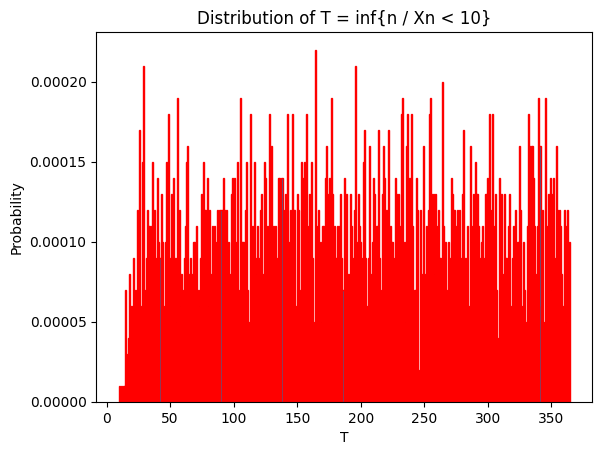

In [298]:
# Distribution du temps d'arrêt et probabilité d'insolvances


c = 10
num_trials = 40000
P = 365
X_0 = np.array([15] * 5) 
W = np.random.randn(5, max_n) 



T_c = np.array([np.where(np.any(trial < c, axis=0))[0][0] if np.any(np.any(trial < c, axis=0)) else P for trial in liste_de_matrices])

non_atteint = len(T_c[T_c == P]) / len(T_c)
print(f"Probabilité d'insolvabilité : {1 - non_atteint:.2%}")


unique_T, counts_T = np.unique(T_c, return_counts=True)
prob_dist_T = counts_T / np.sum(counts_T)

# Exclude the last value of unique_T (which is max_n)
unique_T = unique_T[unique_T != P]
prob_dist_T = prob_dist_T[:len(unique_T)]

# Plotting the distribution of T for the condition Xn < c
plt.bar(unique_T, prob_dist_T, edgecolor='red')
plt.title(f'Distribution of T = inf{{n / Xn < {c}}}')
plt.xlabel('T')
plt.ylabel('Probability')
plt.show()





In [299]:
liste_de_matrices
listes_impactées = np.array(liste_de_matrices)[T_c<365]
indices=np.where(T_c<365)[0]
print(indices)
print(listes_impactées[0])

[   55    80    99 ... 99914 99934 99981]
[[15.         15.10557554 15.10204463 ... 16.86307519 16.95719272
  16.63126699]
 [15.         15.09480609 15.39345871 ... 14.35181858 14.14173789
  13.50954212]
 [15.         15.09049051 14.68204684 ... 11.15175596 11.25531979
  12.14810284]
 [15.         14.71619567 14.30242092 ... 13.43884921 13.74840633
  14.62779977]
 [15.         15.31843726 16.12016282 ... 12.50465258 13.21126689
  14.15480896]]


In [302]:


def impact_calculate(indice):
    matrix = np.copy(liste_de_matrices[indice])
    debut = T_c[indice]
    impactées = []  # banques insolvables
    impact = 0.0  # Assurez-vous que total_impact est un flottant

    for i in range(debut,P):
        new_impactées_bool = insolvance_1(E, matrix[:, i], C)
        new_impactées = np.where(new_impactées_bool == True)[0]
        
        for j in new_impactées:
            E[j,:]=0
            E[:,j]=0
            if j in impactées:
                continue
            # Calcul de l'impact en s'assurant que c'est un flottant
            print(matrix[j][i])
            additional_impact = matrix[j][i] + (1 - R) * np.sum(E[k, j] for k in range(n) if (k not in new_impactées and k not in impactées))
            impact=impact+additional_impact
            # Ajustement de la matrice
            matrice_tile = np.tile(E[:, j].reshape(-1, 1), (1, matrix.shape[1]))
            matrix -= (1 - R) * matrice_tile
        
        impactées = np.unique(np.concatenate((impactées, new_impactées))).tolist()
     
    return [impact,1*(len(impactées)==5)]


total_impact = 0
proba_def_total = 0
indices = np.where(T_c < 365)[0]  

for i in indices:
    total_impact += impact_calculate(i)[0]
    proba_def_total += impact_calculate(i)[1]
print("Proba de la défaillance de tout le système :", proba_def_total / num_trials )
print("Impact total :", total_impact / num_trials)


9.950997329968704
9.950997329968704
9.070743601063622
9.070743601063622
9.909713892772093
9.909713892772093
9.900830148230444
9.900830148230444
9.981454576163328
9.981454576163328
9.947342224571862


C:\Users\zayd\AppData\Local\Temp\ipykernel_9348\3369300463.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  additional_impact = matrix[j][i] + (1 - R) * np.sum(E[k, j] for k in range(n) if (k not in new_impactées and k not in impactées))


9.947342224571862
9.627024495374739
9.627024495374739
9.849287201130567
9.849287201130567
9.534582169323514
9.534582169323514
9.968304941660076
9.953011368224889
9.968304941660076
9.953011368224889
9.598135303039303
9.598135303039303
9.769865921473041
9.769865921473041
9.970253671238073
9.970253671238073
9.957212425597096
9.957212425597096
9.854502690876602
9.854502690876602
9.805787563962918
9.805787563962918
9.877970722643882
9.877970722643882
9.942065548141713
9.942065548141713
9.806289789889934
9.806289789889934
9.826333705188853
9.826333705188853
9.950994502372675
9.950994502372675
9.89180884020439
9.89180884020439
9.972748775848443
9.972748775848443
9.919180350678122
9.919180350678122
9.74958918085823
9.74958918085823
9.77300339205547
9.77300339205547
9.936232374112366
9.936232374112366
9.975747598701288
9.975747598701288
9.970507615661871
9.970507615661871
9.99049536547741
9.99049536547741
9.894931250469845
9.894931250469845
9.897092694870306
9.897092694870306
9.738796318092824
